# Homework 2
**Yibo Xu, 6299196**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import math
from scipy import stats

In [75]:
class Environment:
    def __init__(self):
        self.node = []
        self.reward = dict()
        self.reward.clear()
        self.edge = dict()
        self.edge.clear()
        return
    def add_node(self, node, reward=0):
        # node: number
        # property: 'L', 'R', 'C'
        self.node.append(node)
        # self.reward.append(reward)
        self.reward[node] = reward
    def add_edge(self, node1, node2, property=None, probability=-1):
        if self.edge.get(node1) == None:
            self.edge[node1] = []
        self.edge[node1].append((node2, property, probability))
    def check(self):
        print("Node: ", self.node)
        print("Reward: ", self.reward)
        print("Edge:\n")
        for key, value in self.edge.items():
            print(key, ":", value)

In [152]:
class Agent():
    def __init__(self, env, lrCritic=0.1, lrActor=0.1, stochasticity=0.1, totalTrial=1000):
        self.state = env.node.copy()
        self.critic = dict()
        self.critic.clear()
        self.actor = dict()
        self.actor.clear()
        for i in range(len(self.state)):
            self.critic[self.state[i]] = 0
        for key, value in env.edge.items():
            for i in range(len(value)):
                # print(value[i])
                self.actor[Agent.pair_code(key, value[i][0])] = 0
        self.lrCritic = lrCritic
        self.lrActor = lrActor
        self.stochasticity = stochasticity
        self.totalTrial = totalTrial
        # self.recordCritic = np.zeros((len(self.state), totalTrial))
        self.recordCritic = dict()
        self.recordCritic.clear()
        for i in range(len(self.state)):
            self.recordCritic[self.state[i]] = np.zeros(totalTrial)
        self.recordActor = dict()
        self.recordActor.clear()
        for key, value in self.actor.items():
            self.recordActor[key] = np.zeros(totalTrial)
    @staticmethod
    def pair_code(node1, node2):
        return node1*100 + node2
    @staticmethod
    def pair_decode(pair):
        return pair//100, pair%100
    def reset(self, lrCritic=0.1, lrActor=0.1, stochasticity=0.1, randomActor=False):
        for i in range(len(self.state)):
            self.critic[i] = 0
        for key, value in self.actor.items():
            if randomActor:
                self.actor[key] = np.random.normal(0, 0.5)
            else:
                self.actor[key] = 0
        self.lrCritic = lrCritic
        self.lrActor = lrActor
        self.stochasticity = stochasticity
        return
    def choose_action(self, state, env):
        prob = []
        if env.edge.get(state) == None:
            return None
        if env.edge[state][0][2] == -1:
            for i in range(len(env.edge[state])):
                prob.append(self.actor[Agent.pair_code(state, env.edge[state][i][0])])
            prob = np.array(prob)
            prob = np.exp(prob*self.stochasticity)
            prob = prob/sum(prob)
        else:
            for i in range(len(env.edge[state])):
                prob.append(env.edge[state][i][2])
        # aim = np.zeros(len(prob), dtype=int)
        # for i in range(len(prob)):
        #     aim[i] = env.edge[state][i][0]
        # print(aim)
        return np.random.choice(range(len(prob)), p=prob)
    def learn(self, env, initialState):
        # online learning
        state = initialState
        while True:
            reward = env.reward[state]
            if env.edge.get(state) == None:
                delta = reward - self.critic[state]
                self.critic[state] += self.lrCritic*delta
                break
            action = self.choose_action(state, env)
            stateNext = env.edge[state][action][0]
            delta = reward + self.critic[stateNext] - self.critic[state]
            self.critic[state] += self.lrCritic*delta
            self.actor[Agent.pair_code(state, stateNext)] = (1-self.lrActor)*self.actor[Agent.pair_code(state, stateNext)] + self.lrActor*delta
            for statePotential in env.edge[state]:
                if statePotential[0] != stateNext:
                    self.actor[Agent.pair_code(state, statePotential[0])] = (1-self.lrActor)*self.actor[Agent.pair_code(state, statePotential[0])]
            state = stateNext
        return
    def learn_critic(self, env, initialState):
        # online learning
        state = initialState
        while True:
            reward = env.reward[state]
            if env.edge.get(state) == None:
                delta = reward - self.critic[state]
                self.critic[state] += self.lrCritic*delta
                break
            action = self.choose_action(state, env)
            stateNext = env.edge[state][action][0]
            delta = reward + self.critic[stateNext] - self.critic[state]
            self.critic[state] += self.lrCritic*delta
            state = stateNext
        return
    def record(self, trial):
        for i in range(len(self.state)):
            self.recordCritic[self.state[i]][trial] = self.critic[self.state[i]]
        for key, value in self.actor.items():
            self.recordActor[key][trial] = value
        return
    def run(self, env, initialState, learn_critic=False):
        state = initialState
        for epoch in range(self.totalTrial):
            if learn_critic:
                self.learn_critic(env, state)
            else:
                self.learn(env, state)
            self.record(epoch)
        return state

class AgentStats:
    def __init__(self, agent):
        self.totalTrial = agent.totalTrial
        # self.criticStats = np.zeros((len(agent.state), agent.totalTrial))
        self.criticStats = dict()
        self.criticStats.clear()
        for i in range(len(agent.state)):
            self.criticStats[agent.state[i]] = np.zeros(agent.totalTrial)
        self.actorStats = dict()
        self.actorStats.clear()
        for key, value in agent.actor.items():
            self.actorStats[key] = np.zeros(agent.totalTrial)
    def reset(self):
        self.criticStats.fill(0)
        self.actorStats = dict()
        for key, value in self.actorStats.items():
            self.actorStats[key].fill(0)

In [163]:
def plot_critic(agent, stats, focus):
    for i in range(0, len(agent.state)):
        if agent.state[i] not in focus:
            continue
        # print(agent.recordCritic[i].shape)
        plt.plot(agent.recordCritic[agent.state[i]], label="Critic of one run", linestyle='dotted')
        plt.plot(stats.criticStats[agent.state[i]], label="Critic of all runs", linestyle='solid')
        plt.xlabel("Trial")
        plt.ylabel("Critic")
        plt.title("Critic for state " + str(agent.state[i]))
        plt.legend()
        plt.show()
    return
def plot_tree_actor(stats: AgentStats, env: Environment, stochasticity=0.1, focus=[]):
    def choose_direction(edgeProperty):
        if edgeProperty == 'L':
            return 0
        elif edgeProperty == 'R':
            return 1
        else:
            return 2
    def choose_label(number):
        if number == 0:
            return 'L'
        elif number == 1:
            return 'R'
        else:
            return 'C'
    def choose_linestyle(edgeProperty):
        if edgeProperty == 0:
            return 'solid'
        elif edgeProperty == 1:
            return 'dashed'
        else:
            return 'dotted'
    maxDegree = 0
    for key, value in env.edge.items():
        if len(value) > maxDegree:
            maxDegree = len(value)
    prob = np.zeros((maxDegree, stats.totalTrial))
    valid = []
    for node in env.node:
        if env.edge.get(node) == None:
            continue
        if node not in focus:
            continue
        prob.fill(0)
        valid = []
        for target in env.edge[node]:
            # print("Target: ", target)
            # order L, R, C
            edge = Agent.pair_code(node, target[0])
            prob[choose_direction(target[1])] = stats.actorStats[edge]
            valid.append(choose_direction(target[1]))
            # if np.sum(prob[choose_direction(target[1])]) > 0:
            # valid[choose_direction(target[1])] = 1
            # plt.plot(agent.recordActor[agent.pair_code(key, value[i])], label="Actor of one run", linestyle='.')
            # plt.plot(stats.actorStats[agent.pair_code(key, value[i])], label="Actor of all runs", linestyle='--')
        prob = np.exp(prob*stochasticity)
        # print(prob[valid].shape)
        # print(prob[valid, :10], np.sum(prob[valid, :10], axis=0), np.divide(prob[valid, :10], np.sum(prob[valid, :10], axis=0)))
        # break
        prob[valid] = np.divide(prob[valid], np.sum(prob[valid], axis=0))
        # print(prob[valid, :10])
        for i in range(len(valid)):
            plt.plot(prob[valid[i]], label=choose_label(valid[i]), linestyle=choose_linestyle(valid[i]))
        plt.xlabel("Trial")
        plt.ylabel("Probability P[a|s]")
        plt.title("Actor for state " + str(node))
        plt.legend()
        plt.show()
    return

In [160]:
def build_tree():
    tree = Environment()
    tree.add_node(1, reward=0)
    tree.add_node(2, reward=0)
    tree.add_node(3, reward=0)
    tree.add_node(4, reward=1) # L of 1
    tree.add_node(5, reward=2) # R of 1
    tree.add_node(6, reward=-1) # C of 1
    tree.add_node(7, reward=8) # L of 2
    tree.add_node(8, reward=-8) # R of 2
    tree.add_node(9, reward=0) # L of 3
    tree.add_node(10, reward=4) # R of 3
    tree.add_edge(1, 4, property='L')
    tree.add_edge(1, 5, property='R')
    tree.add_edge(1, 6, property='C')
    tree.add_edge(2, 7, property='L')
    tree.add_edge(2, 8, property='R')
    tree.add_edge(3, 9, property='L')
    tree.add_edge(3, 10, property='R')
    tree.add_edge(6, 2, probability=0.5)
    tree.add_edge(6, 3, probability=0.5)
    return tree

def main_tree():
    tree = build_tree()
    # lrCritic=0.2, lrActor=0.075, stochasticity=1 by default in the textbook
    agent = Agent(tree, lrCritic=0.2, lrActor=0.075, stochasticity=1, totalTrial=1000)
    stats = AgentStats(agent)
    totalRun = 100
    for i in range(totalRun):
        agent.run(tree, 1)
        # stats.criticStats += agent.recordCritic
        for key, value in agent.recordCritic.items():
            stats.criticStats[key] += value
        for key, value in agent.recordActor.items():
            stats.actorStats[key] += value
        agent.reset(lrCritic=0.2, lrActor=0.075, stochasticity=1, randomActor=False)
    for key, value in stats.criticStats.items():
        stats.criticStats[key] /= totalRun
    for key, value in stats.actorStats.items():
        stats.actorStats[key] /= totalRun
    plot_critic(agent, stats, focus=[1, 2, 3])
    plot_tree_actor(stats, tree, stochasticity=1, focus=[1, 2, 3])
    return

In [161]:
def main_critic():
    tree = build_tree()
    # lrCritic=0.2, lrActor=0.075, stochasticity=1 by default in the textbook
    agent = Agent(tree, lrCritic=0.2, lrActor=0.075, stochasticity=1, totalTrial=1000)
    stats = AgentStats(agent)
    totalRun = 100
    for i in range(totalRun):
        agent.run(tree, 1, learn_critic=True)
        # stats.criticStats += agent.recordCritic
        for key, value in agent.recordCritic.items():
            stats.criticStats[key] += value
        agent.reset(lrCritic=0.2, lrActor=0.075, stochasticity=1, randomActor=True)
    for key, value in stats.criticStats.items():
        stats.criticStats[key] /= totalRun
    plot_critic(agent, stats, focus=[1, 2, 3])
    return

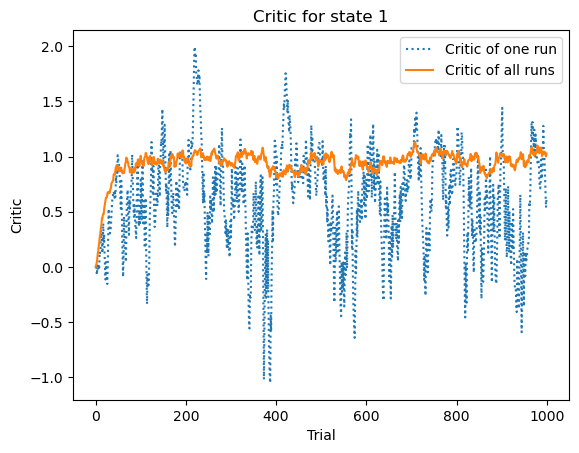

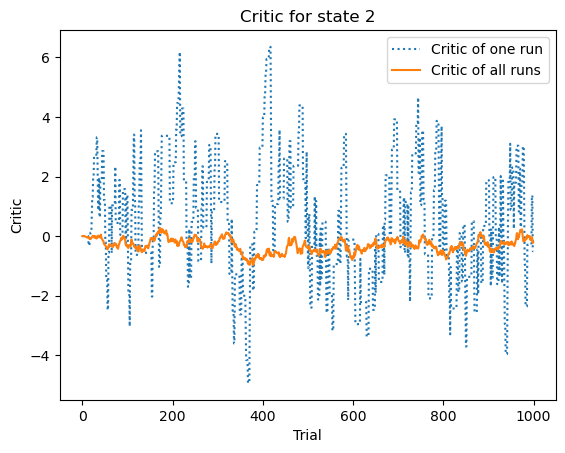

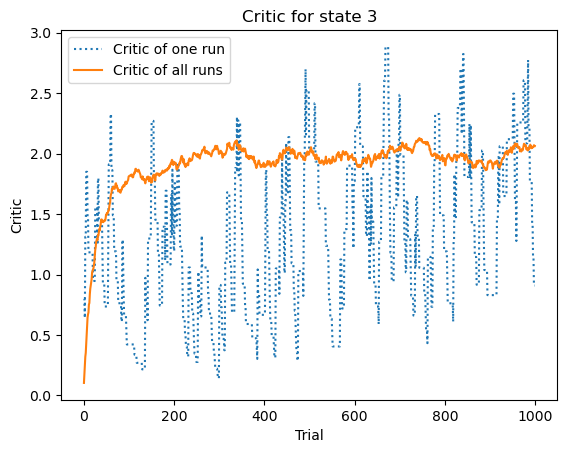

In [164]:
main_critic()

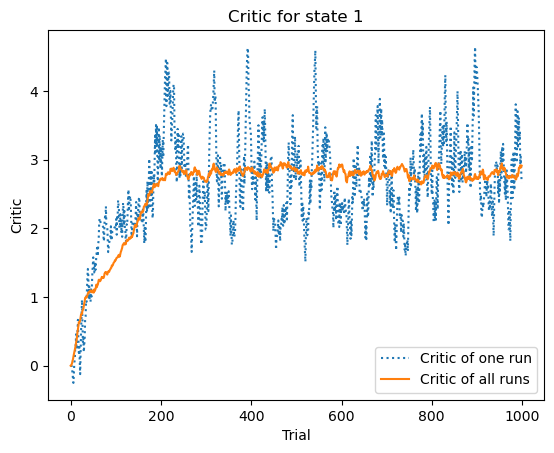

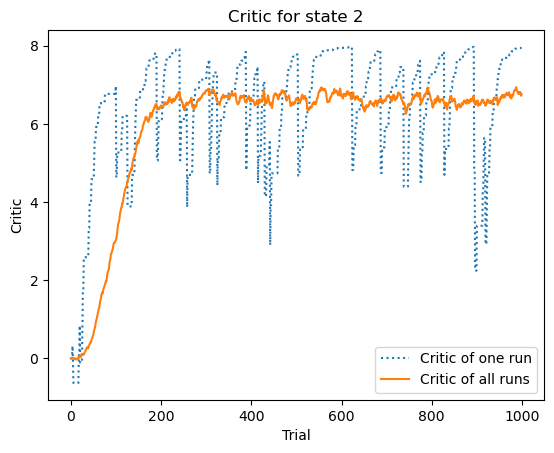

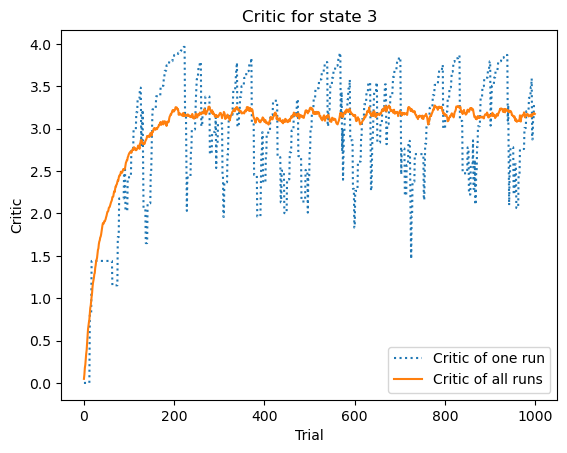

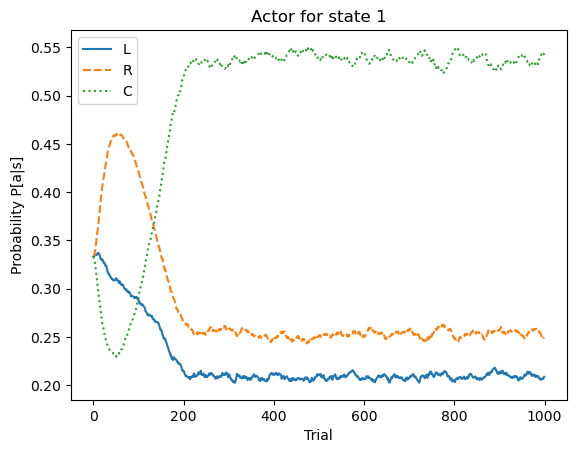

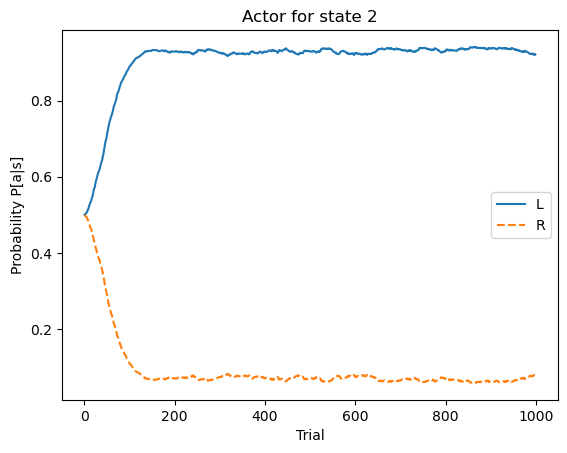

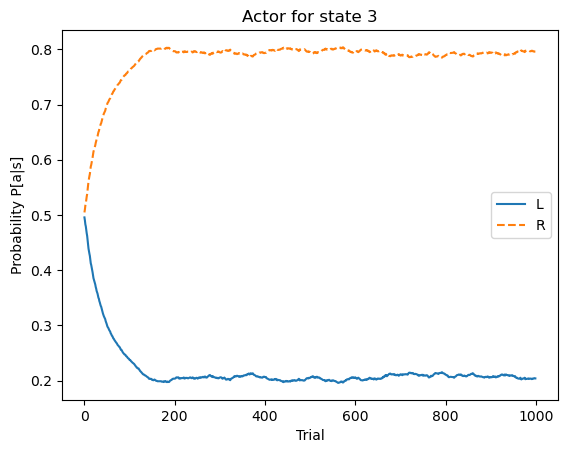

In [165]:
main_tree()

In [156]:
def build_maze():
    maze = Environment()
    maze.add_node(1, reward=0)
    maze.add_node(2, reward=0)
    maze.add_node(3, reward=0)
    maze.add_node(4, reward=0)
    maze.add_node(5, reward=1)
    maze.add_node(6, reward=2)
    maze.add_node(7, reward=3)
    maze.add_node(8, reward=4)
    maze.add_edge(1, 2, property='R')
    maze.add_edge(2, 3, property='R')
    maze.add_edge(3, 4, property='R')
    maze.add_edge(4, 1, property='R')
    maze.add_edge(1, 5, property='L')
    maze.add_edge(2, 6, property='L')
    maze.add_edge(3, 7, property='L')
    maze.add_edge(4, 8, property='L')
    return maze

def main_maze():
    maze = build_maze()
    # lrCritic=0.2, lrActor=0.075, stochasticity=1 by default in the textbook
    agent = Agent(maze, lrCritic=0.2, lrActor=0.075, stochasticity=1, totalTrial=1000)
    stats = AgentStats(agent)
    totalRun = 100
    for i in range(totalRun):
        agent.run(maze, 1)
        # stats.criticStats += agent.recordCritic
        for key, value in agent.recordCritic.items():
            stats.criticStats[key] += value
        for key, value in agent.recordActor.items():
            stats.actorStats[key] += value
        agent.reset(lrCritic=0.2, lrActor=0.075, stochasticity=1, randomActor=False)
    for key, value in stats.criticStats.items():
        stats.criticStats[key] /= totalRun
    for key, value in stats.actorStats.items():
        stats.actorStats[key] /= totalRun
    plot_critic(agent, stats)
    plot_tree_actor(stats, maze, stochasticity=1)

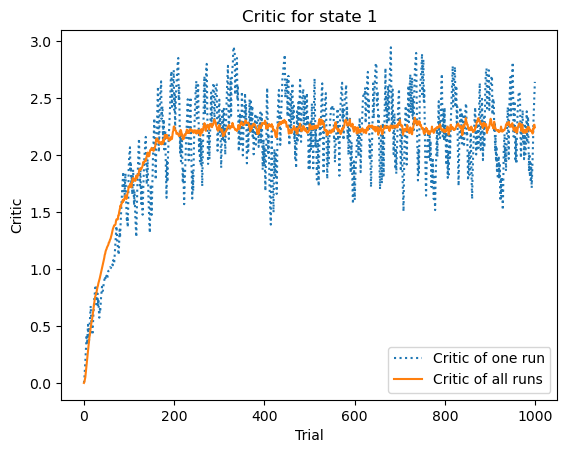

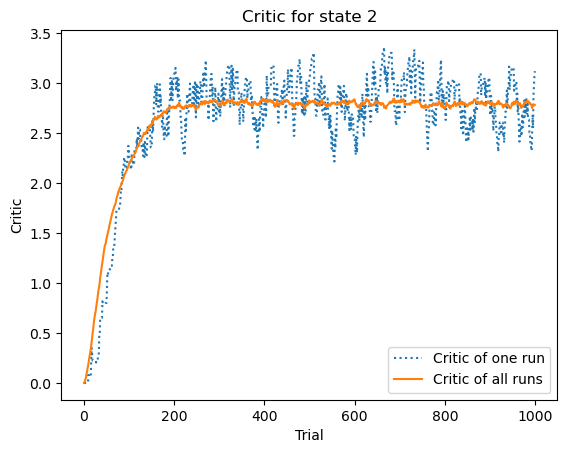

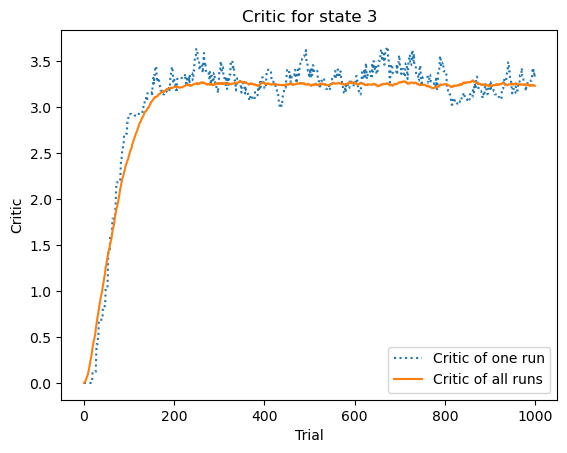

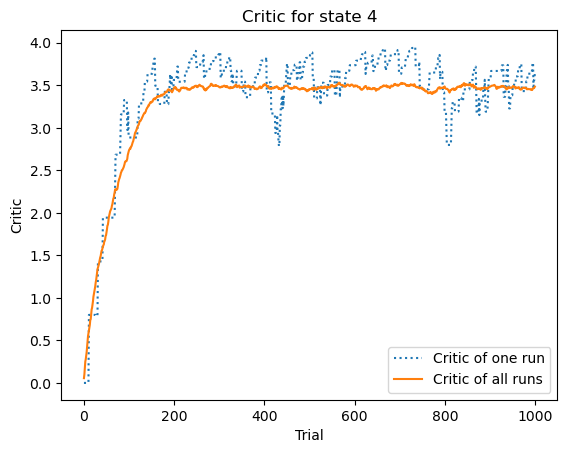

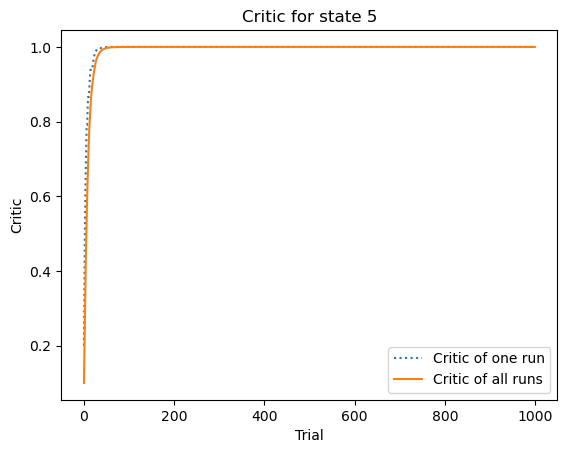

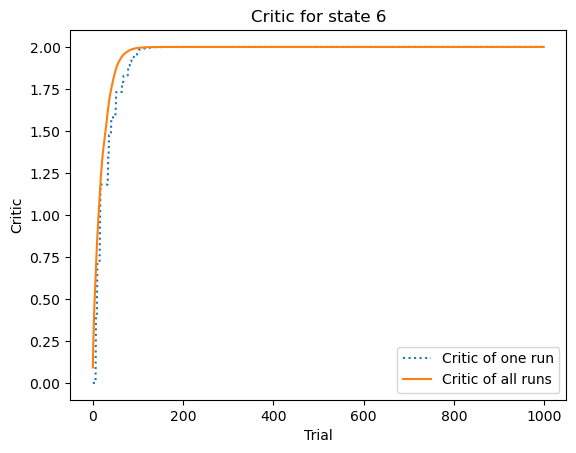

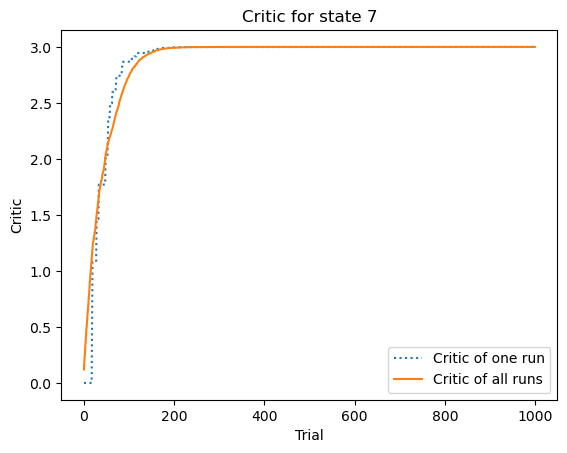

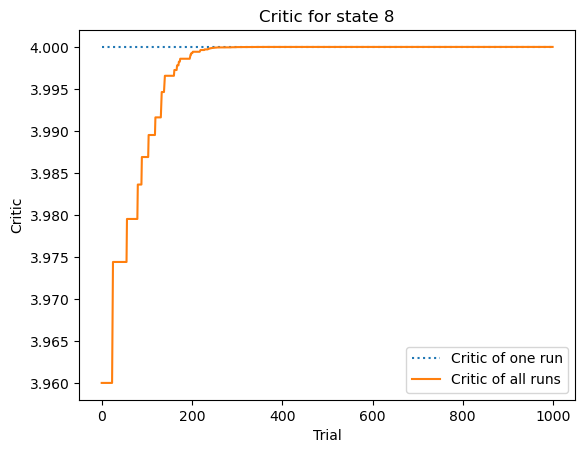

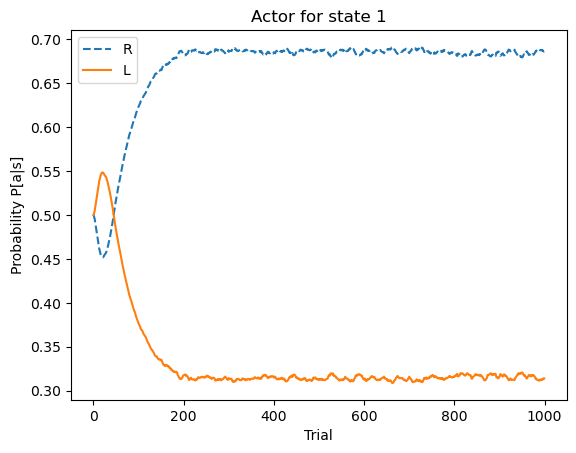

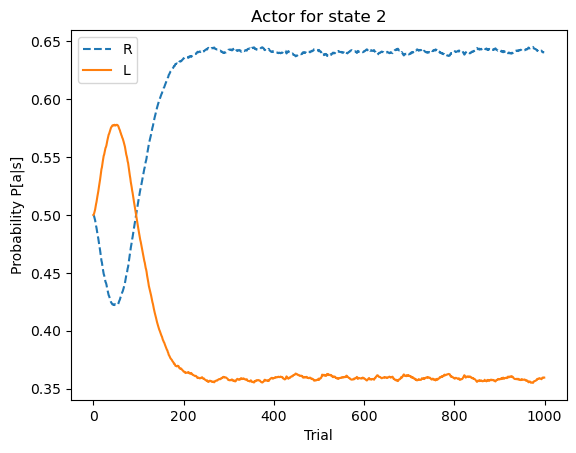

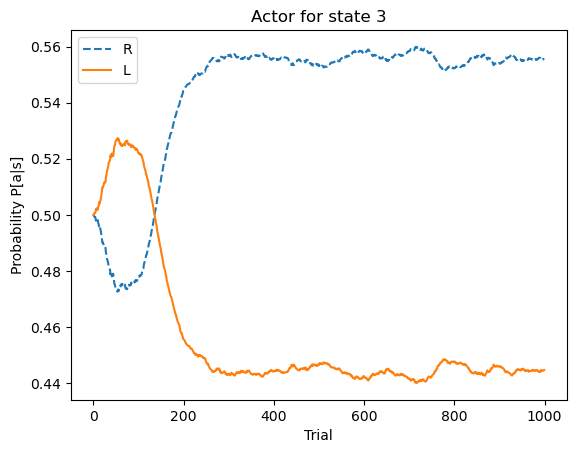

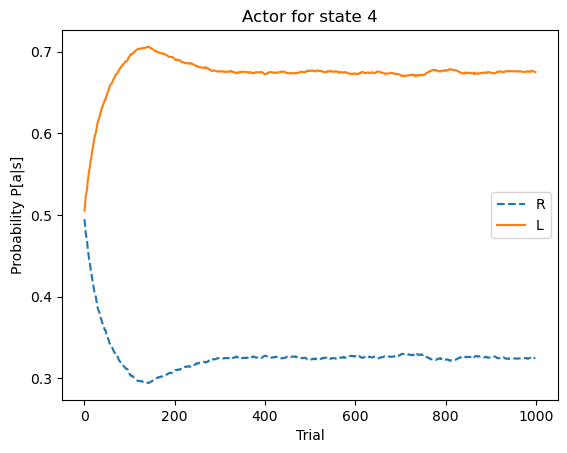

In [157]:
main_maze()